In [2]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

In [64]:
mercari_df = pd.read_csv("train.tsv", sep = '\t')
mercari_df.shape
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# Data Cleaning

In [66]:
# Check the Feature Type and Null Value
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [81]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [68]:
# From the table above
# 0) No need to touch [Train_id] and [name] 
# 1) [item_condition_id] ???
# 2) [Category_name] has also roughly 6,300 of null values
# 3) [Brand_name] has 632,682 of null values
# 4) [Price] is my target-variable
# 5) [shipping] ???
# 6) 4 of non-value for [Item-description]


In [69]:
# 1. [item_condition_id]
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [78]:
# 2) [Category_name] has also roughly 6,300 of null values

mercari_df["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Pets/Tag                                     1
Handmade/Knitting/Cozy                                1
Handmade/Pets/Blanket                                 1
Handmade/Bags and Purses/Other                        1
Handmade/Children/Furniture                           1
Name: category_name, Length: 1287, dtype: int64

In [ ]:
# tokeniser?

In [70]:
# 3) [Brand_name] has almost half of null values
mercari_df['brand_name'].value_counts()

PINK                     54088
Nike                     54043
Victoria's Secret        48036
LuLaRoe                  31024
Apple                    17322
                         ...  
Lilli Ann                    1
Persol                       1
Beverly Drive                1
C. O. Bigelow                1
plenty by Tracy Reese        1
Name: brand_name, Length: 4809, dtype: int64

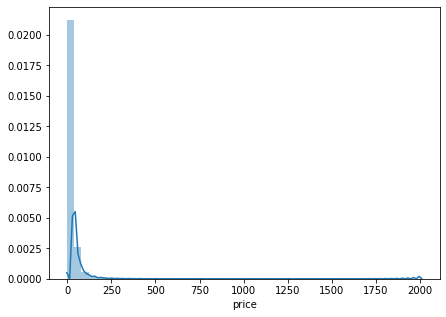

In [71]:
# 4) [Price] is my target-variable
y_train_df = mercari_df.price
plt.figure(figsize=(7,5))
sns.distplot(y_train_df, kde=True)

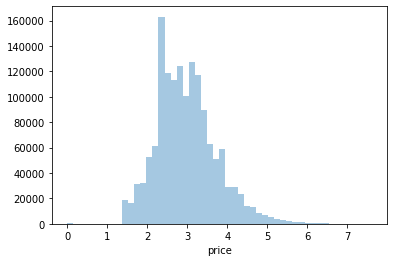

In [72]:
# Price is wrongly distributed so i use log function to make it close to the normal distibution.
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)

In [73]:
# Now, it looks like normal distribution now
mercari_df.price= np.log1p(mercari_df.price)
mercari_df.price.head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [74]:
# 5) [shipping] 
mercari_df.shipping.value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

In [55]:
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [76]:
# 6) 4 of non-value for [Item-description] and Found 82,489 of "No description"
mercari_df["item_description"].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                                                                                    82489
New                                                                                                                                                                                                                                                                                                                                                                                                                    4099
Brand new                                                                                                                                                                       

In [61]:
mercari_df["item_description"].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                                                                                    82489
New                                                                                                                                                                                                                                                                                                                                                                                                                    4099
Brand new                                                                                                                                                                       

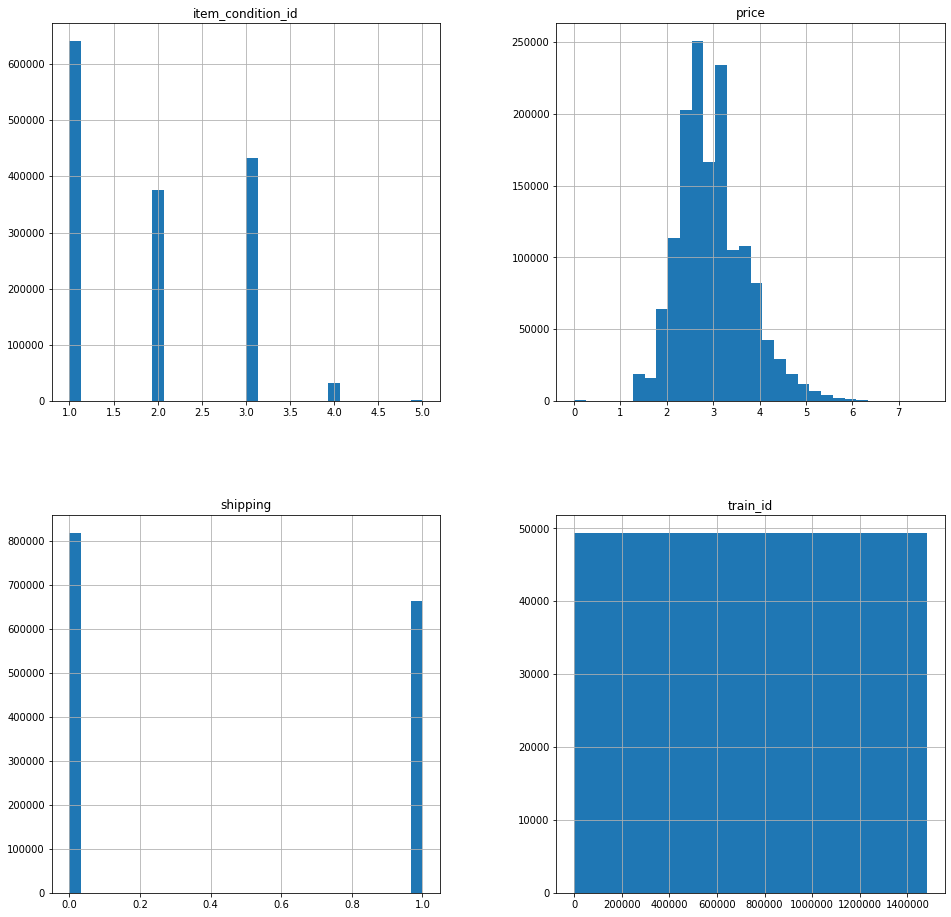

In [79]:
mercari_df.hist(bins=30, figsize=(16,16))
plt.show()

# Feature Encoding/Feature Vectorisation

In [82]:
# One Hot coding
# count Vector (Short words)
# TD-IDF (Long words)

In [93]:
mercari_df['brand_name'].unique()


array([nan, 'Razer', 'Target', ..., 'Astroglide', 'Cumberland Bay',
       'Kids Only'], dtype=object)

In [87]:
b1 = mercari_df['brand_name'].value_counts()
b1.head()

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
Name: brand_name, dtype: int64